## 1. Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. Load and Explore Data

In [3]:
# Load the processed data for BAJFINANCE
stock_name = 'BAJFINANCE'
data_path = f'stock_data_daily_processed/{stock_name}_daily_data.csv'

# Read CSV - skip row 1 (ticker names) and row 2 (Date label), use row 0 as header
df = pd.read_csv(data_path, skiprows=[1, 2], index_col=0, parse_dates=True)

# Rename the index to 'Date' for clarity
df.index.name = 'Date'

print(f"Data shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nData info:")
print(df.info())
print(f"\nMissing values:")
print(df.isnull().sum())
print(f"\nTarget distribution:")
print(df['target'].value_counts())

Data shape: (1481, 23)

First few rows:
                 Close        High         Low        Open   Volume  \
Date                                                                  
2018-01-01  168.066772  171.412230  167.555449  171.363531  5353190   
2018-01-02  167.969360  169.435134  166.542552  169.435134  5762080   
2018-01-03  167.058746  169.303670  166.639962  168.198246  4161360   
2018-01-04  170.827866  171.241790  166.932133  168.003465  7301470   
2018-01-05  176.720169  177.353235  171.324586  171.996602  9843270   

            day_of_week  month  day_of_week_sin  day_of_week_cos  month_sin  \
Date                                                                          
2018-01-01            0      1         0.000000         1.000000        0.5   
2018-01-02            1      1         0.781831         0.623490        0.5   
2018-01-03            2      1         0.974928        -0.222521        0.5   
2018-01-04            3      1         0.433884        -0.900969   

## 3. Data Preprocessing

In [4]:
# Remove rows with missing values
df_clean = df.dropna()
print(f"Shape after removing NaN: {df_clean.shape}")

# Separate features and target
feature_cols = [col for col in df_clean.columns if col != 'target']
X = df_clean[feature_cols].values
y = df_clean['target'].values

# Convert target: -1 -> 0 (down), 0 -> 1 (no change), 1 -> 2 (up)
# For binary classification, let's convert to: -1 or 0 -> 0 (down/neutral), 1 -> 1 (up)
y_binary = (y == 1).astype(int)

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y_binary.shape}")
print(f"Binary target distribution: {np.bincount(y_binary)}")

Shape after removing NaN: (1462, 23)

Features shape: (1462, 22)
Target shape: (1462,)
Binary target distribution: [736 726]


## 4. Create Sequences for LSTM

In [5]:
def create_sequences(X, y, sequence_length):
    """
    Create sequences for LSTM input
    X: features array
    y: target array
    sequence_length: number of time steps to look back
    """
    X_seq, y_seq = [], []
    
    for i in range(len(X) - sequence_length):
        X_seq.append(X[i:i+sequence_length])
        y_seq.append(y[i+sequence_length])
    
    return np.array(X_seq), np.array(y_seq)

# Set sequence length (lookback window)
SEQUENCE_LENGTH = 20

# Create sequences
X_seq, y_seq = create_sequences(X, y_binary, SEQUENCE_LENGTH)

print(f"Sequence shape: {X_seq.shape}")  # (samples, sequence_length, features)
print(f"Target shape: {y_seq.shape}")
print(f"Target distribution in sequences: {np.bincount(y_seq)}")

Sequence shape: (1442, 20, 22)
Target shape: (1442,)
Target distribution in sequences: [725 717]


## 5. Train-Test Split and Scaling

In [6]:
# Split data temporally (don't shuffle for time series)
train_size = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")
print(f"Train target distribution: {np.bincount(y_train)}")
print(f"Test target distribution: {np.bincount(y_test)}")

# Scale the features
scaler = StandardScaler()

# Reshape to 2D for scaling
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

# Fit on train, transform both
scaler.fit(X_train_reshaped)
X_train_scaled = scaler.transform(X_train_reshaped).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape)

print(f"\nScaled train shape: {X_train_scaled.shape}")
print(f"Scaled test shape: {X_test_scaled.shape}")

Train set: (1153, 20, 22), (1153,)
Test set: (289, 20, 22), (289,)
Train target distribution: [565 588]
Test target distribution: [160 129]

Scaled train shape: (1153, 20, 22)
Scaled test shape: (289, 20, 22)


## 6. Create PyTorch Dataset and DataLoader

In [7]:
class StockDataset(Dataset):
    """Custom Dataset for stock sequences"""
    
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = StockDataset(X_train_scaled, y_train)
test_dataset = StockDataset(X_test_scaled, y_test)

# Create dataloaders
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 37
Number of test batches: 10


## 7. Define LSTM Model Architecture

In [8]:
class LSTMModel(nn.Module):
    """
    Baseline LSTM model for stock price prediction
    """
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.2):
        super(LSTMModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, num_classes)
        
    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Get the output from the last time step
        out = out[:, -1, :]
        
        # Apply dropout
        out = self.dropout(out)
        
        # Pass through fully connected layers
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

# Model hyperparameters
INPUT_SIZE = X_train_scaled.shape[2]  # Number of features
HIDDEN_SIZE = 128
NUM_LAYERS = 2
NUM_CLASSES = 2  # Binary classification
DROPOUT = 0.3

# Initialize model
model = LSTMModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES, DROPOUT).to(device)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

LSTMModel(
  (lstm): LSTM(22, 128, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

Total parameters: 218306


## 8. Define Loss Function and Optimizer

In [9]:
# Loss function - CrossEntropyLoss for classification
criterion = nn.CrossEntropyLoss()

# Optimizer - Adam
LEARNING_RATE = 0.001
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

print(f"Criterion: {criterion}")
print(f"Optimizer: {optimizer}")
print(f"Scheduler: {scheduler}")

Criterion: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7ff0dfdcb050>


## 9. Training and Evaluation Functions

In [10]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc


def evaluate(model, dataloader, criterion, device):
    """Evaluate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # Statistics
            running_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc, np.array(all_preds), np.array(all_labels)

print("Training and evaluation functions defined.")

Training and evaluation functions defined.


## 10. Train the Model

In [13]:
NUM_EPOCHS = 50

# Track history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_loss = float('inf')
patience_counter = 0
early_stop_patience = 50

print(f"Training for {NUM_EPOCHS} epochs...")
print("="*70)

for epoch in range(NUM_EPOCHS):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Evaluate
    val_loss, val_acc, _, _ = evaluate(model, test_loader, criterion, device)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_lstm_model.pth')
    else:
        patience_counter += 1
    
    if patience_counter >= early_stop_patience:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

print("="*70)
print("Training completed!")

Training for 50 epochs...
Epoch [1/50] Train Loss: 0.6545, Train Acc: 0.6097 | Val Loss: 0.8077, Val Acc: 0.4740
Epoch [5/50] Train Loss: 0.6473, Train Acc: 0.6184 | Val Loss: 0.8528, Val Acc: 0.4671
Epoch [10/50] Train Loss: 0.6308, Train Acc: 0.6418 | Val Loss: 0.8496, Val Acc: 0.4740
Epoch [15/50] Train Loss: 0.6255, Train Acc: 0.6418 | Val Loss: 0.9072, Val Acc: 0.4671
Epoch [20/50] Train Loss: 0.6173, Train Acc: 0.6513 | Val Loss: 0.9251, Val Acc: 0.4706
Epoch [25/50] Train Loss: 0.6210, Train Acc: 0.6635 | Val Loss: 0.9363, Val Acc: 0.4706
Epoch [30/50] Train Loss: 0.6177, Train Acc: 0.6531 | Val Loss: 0.9435, Val Acc: 0.4706
Epoch [35/50] Train Loss: 0.6156, Train Acc: 0.6696 | Val Loss: 0.9415, Val Acc: 0.4706
Epoch [40/50] Train Loss: 0.6203, Train Acc: 0.6565 | Val Loss: 0.9438, Val Acc: 0.4671
Epoch [45/50] Train Loss: 0.6159, Train Acc: 0.6635 | Val Loss: 0.9440, Val Acc: 0.4671
Epoch [50/50] Train Loss: 0.6180, Train Acc: 0.6522 | Val Loss: 0.9450, Val Acc: 0.4671
Training

## 11. Plot Training History

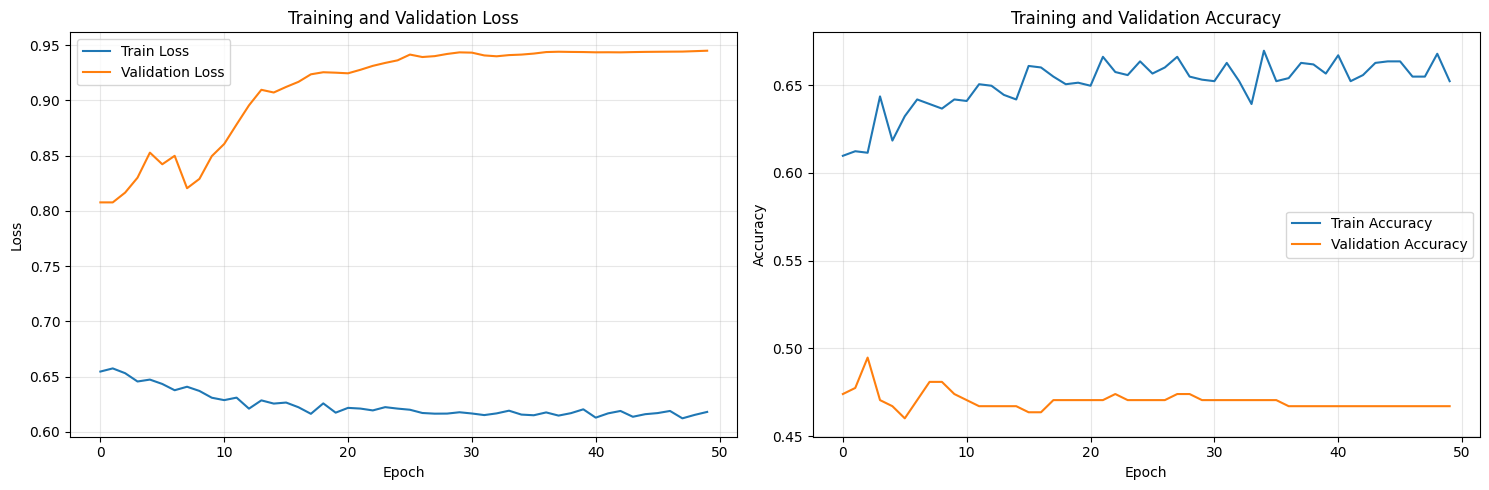

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
axes[0].plot(history['train_loss'], label='Train Loss')
axes[0].plot(history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot accuracy
axes[1].plot(history['train_acc'], label='Train Accuracy')
axes[1].plot(history['val_acc'], label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 12. Load Best Model and Final Evaluation

In [15]:
# Load best model
model.load_state_dict(torch.load('best_lstm_model.pth'))
model.eval()

# Evaluate on test set
test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion, device)

print("="*70)
print("FINAL TEST SET RESULTS")
print("="*70)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print()

# Classification report
print("Classification Report:")
print(classification_report(test_labels, test_preds, target_names=['Down/Neutral', 'Up']))

# Additional metrics
precision = precision_score(test_labels, test_preds, average='binary')
recall = recall_score(test_labels, test_preds, average='binary')
f1 = f1_score(test_labels, test_preds, average='binary')

print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

FINAL TEST SET RESULTS
Test Loss: 0.8077
Test Accuracy: 0.4775

Classification Report:
              precision    recall  f1-score   support

Down/Neutral       0.55      0.34      0.42       160
          Up       0.44      0.65      0.53       129

    accuracy                           0.48       289
   macro avg       0.49      0.49      0.47       289
weighted avg       0.50      0.48      0.47       289


Precision: 0.4421
Recall: 0.6512
F1-Score: 0.5266


## 13. Confusion Matrix

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Down/Neutral', 'Up'],
            yticklabels=['Down/Neutral', 'Up'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LSTM Baseline Model')
plt.tight_layout()
plt.show()

# Calculate percentage
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
print("\nConfusion Matrix (Percentages):")
print(cm_percent)

## 14. Model Summary and Key Insights

In [ ]:
print("="*70)
print("BASELINE LSTM MODEL SUMMARY")
print("="*70)
print(f"\nStock: {stock_name}")
print(f"Data Shape: {df_clean.shape}")
print(f"Sequence Length: {SEQUENCE_LENGTH}")
print(f"Train Samples: {len(X_train)}")
print(f"Test Samples: {len(X_test)}")
print(f"\nModel Architecture:")
print(f"  - Input Features: {INPUT_SIZE}")
print(f"  - Hidden Size: {HIDDEN_SIZE}")
print(f"  - Number of LSTM Layers: {NUM_LAYERS}")
print(f"  - Dropout: {DROPOUT}")
print(f"  - Total Parameters: {sum(p.numel() for p in model.parameters())}")
print(f"\nTraining Configuration:")
print(f"  - Batch Size: {BATCH_SIZE}")
print(f"  - Learning Rate: {LEARNING_RATE}")
print(f"  - Epochs Trained: {len(history['train_loss'])}")
print(f"  - Optimizer: Adam")
print(f"  - Loss Function: CrossEntropyLoss")
print(f"\nPerformance Metrics:")
print(f"  - Test Accuracy: {test_acc:.4f}")
print(f"  - Test Loss: {test_loss:.4f}")
print(f"  - Precision: {precision:.4f}")
print(f"  - Recall: {recall:.4f}")
print(f"  - F1-Score: {f1:.4f}")
print("="*70)

## Next Steps and Potential Improvements

### Baseline Model Complete ✓
This notebook implements a baseline LSTM model with the following characteristics:
- **Binary classification**: Predicting if price goes up (1) or down/neutral (0)
- **Sequence-based learning**: Uses 20-day lookback window
- **2-layer LSTM**: 128 hidden units with dropout regularization
- **Temporal split**: 80/20 train-test split preserving time order

### Potential Improvements:
1. **Multi-class classification**: Predict all three classes (-1, 0, 1) instead of binary
2. **Hyperparameter tuning**: Grid search for optimal sequence length, hidden size, layers
3. **Feature engineering**: Add sentiment features from `final_sentiment_features/`
4. **Attention mechanism**: Add attention layers to focus on important time steps
5. **Bidirectional LSTM**: Capture both forward and backward temporal patterns
6. **Ensemble methods**: Combine with other models (GRU, Transformer)
7. **Cross-validation**: Implement time-series cross-validation
8. **Multi-stock training**: Train on all 10 stocks simultaneously
9. **Class balancing**: Handle imbalanced target distribution with weighted loss
10. **Advanced architectures**: Try Transformer or temporal convolutional networks

### To Train on Other Stocks:
Simply change the `stock_name` variable to one of:
- BAJFINANCE
- BHARTIARTL
- HDFCBANK
- HINDUNILVR
- ICICIBANK
- INFY
- KOTAKBANK
- RELIANCE
- SBIN
- TCS